# **Artificial Intelligence, Project 2,**
## <span style="color:RGB(30, 190, 250)">Genetic, SA, and Hill Climbing for Cutting Stock Problem

### Mobin Roohi - Student ID: 610300060
***

This notebook contains code and documentation for the implementation of the following algorithms for the Cutting Stock problem:
 
I.   <span style="color:RGB(30, 190, 250)">**Genetic Algorithm**

II.  <span style="color:RGB(30, 190, 250)">**Simulated Annealing**

III. <span style="color:RGB(30, 190, 250)">**Hill Climbing**

### **Table of Contents**

1. **[Cutting Stock Problem Statement](#one)**
2. **[I. Genetic Algorithm](#two)**
3. **[II. Simulated Annealing](#three)**
4. **[III. Hill Climbing](#four)**

<a id="one"></a>
## <span style="color:RGB(30, 190, 250)">Cutting Stock Problem Statement

The cutting stock problem involves cutting parts with standard sizes from stock materials, such as roll paper or sheet metal, into pieces of specific sizes (requests) while minimizing material wastage. In terms of computational complexity, the problem is NP-hard.
Suppose a paper machine can produce an unlimited number of original rolls, and we have several requests. The objective is to cut these rolls in a way that fulfills all requests using the minimum number of rolls simultaneously. For instance, consider having ten-meter paper rolls and receiving requests for 3, 5, and 7-meter rolls. The following are the optimal solutions for this example using two rolls.
<div style="margin-left: auto; margin-right: auto; width: fit-content;">

<table>
  <tr>
    <td>Waste</td>
    <td>3</td>
    <td>5</td>
  </tr>
</table>

<br>

<table>
  <tr>
    <td>Waste</td>
    <td>7</td>
  </tr>
</table>

</div>


Throughout this notebook we will test our algorihtms on the same set of 4 inputs, to test and compare them.

<a id="two"></a>
## I. <span style="color:RGB(30, 190, 250)">Genetic Algorithm


This implementation of the genetic algorithm involves the following componenets,

1. Chromosome Representation: Permutation Encoding
2. Initial Population: Random Initialization
3. Fitness (Objective) Function: Amount of Wastage
4. Parent Selection: Tournament Selection
5. Recombination: Order Crossover (OX)
6. Mutation: Scramble Mutation
7. Replacement: Steady-State Replacement with Elitism

Using a mix of exploration and exploitation.

First we load the necessary libraries:

+ random: for randomization purposes
+ matpotlib: for plotting the learning curve of the algorithms

In [1]:
import random
import matplotlib.pyplot as plt
import math

and define utility functions for reading input files and plotting data.

In [2]:
def readInput(i):
    with open(f"./input{i}.stock", "r") as file:
        lines = file.readlines()
        for line in lines:
            if line.startswith("Stock Length:"):
                stock_length = int(line.split(":")[1].strip())
            elif line.startswith("Requests:"):
                requests_line = lines[lines.index(line) + 1]
                input = [int(x.strip()) for x in requests_line.split(',')]
    
    return stock_length, input

def plotData(data):
    # Plotting the learning curve
    plt.plot(data)
    plt.title('Learning Curve')
    plt.xlabel('Generation')
    plt.ylabel('Fitness')
    plt.show()


Now, read the input files and define the necessary global variables.

In [3]:
stock_length1, input1 = readInput(1)
stock_length2, input2 = readInput(2)
stock_length3, input3 = readInput(3)
stock_length4, input4 = readInput(4)
requests = []
stock_length = None

Next, we have the `Chromosome` class which represents each individual in the population.

In [4]:
# Chromosome class representing a solution
class Chromosome:
    def __init__(self, alleles):
        # Permutation encoding for the chromosomes
        self.genes = alleles  # genes[i] represents the j-th request processed in i-th order.
        self.fitness = self.fitness()

    def fitness(self):
        stock_wastage = 0
        stock_num = 0
        rem = 0
        for j in self.genes:
            # See if there is a need for a new stock.
            if requests[j] <= rem:
                rem -= requests[j]
            else:
                stock_wastage += rem
                rem = stock_length - requests[j]
                stock_num += 1
        stock_wastage += rem
        
        return -stock_wastage
    
    def stock_needed(self):
        stock_num = 0
        rem = 0
        for j in self.genes:
            # See if there is a need for a new stock.
            if requests[j] <= rem:
                rem -= requests[j]
            else:
                rem = stock_length - requests[j]
                stock_num += 1
        
        return stock_num

Further, we have a `Genotype` class representing the population.

In [5]:
# Genotype representing the population class
class Genotype:
    def __init__(self, popsize):
        if popsize % 2 != 0:
            popsize -= 1
        # Initialize the chromosomes randomly    
        self.chromosomes = [Chromosome(random.sample(range(len(requests)), len(requests))) for _ in range(popsize)]

    def get_fittest(self):
        # Return the chromosome with the highest fitness
        return max(self.chromosomes, key=lambda x: x.fitness)


Finally, we have the main `GeneticAlgorithm` class where genetic algorithm takes place.

In [6]:
class GeneticAlgorithm:
    def __init__(self, population_size, generation_num, mutation_rate, elitism_rate = 0.1, \
                 replacement_rate = 0.4, tournament_size=5):
        self.population = Genotype(population_size)
        self.generation_num = generation_num
        self.mutation_rate = mutation_rate
        self.tournament_size = tournament_size
        self.population_size = population_size
        self.elitism_rate = elitism_rate
        self.replacement_rate = replacement_rate
        # Keep track of the data for plotting the learning curve
        self.learning_curve = []

    def evolve(self):
        for i in range(self.generation_num):
            new_candidates = []

            # Create a new population the same size as the previous population
            for _ in range(self.population_size // 2):
                parent1 = self._tournament_selection()
                parent2 = self._tournament_selection()
                child1, child2 = self._order_crossover(parent1, parent2)
                self._mutate(child1)
                self._mutate(child2)
                new_candidates.extend([child1, child2])

            # Replace the new population with a mix of new and the old.
            self._replace(new_candidates)
            self.learning_curve.append(-self.population.get_fittest().fitness)
            if i % 10 == 0:
                print(f"\033[1;96mFittest Chromosome in Generation {i}:\033[0m\n" + 
                f"\033[0;30m{'Wastage:':<20} {-self.population.get_fittest().fitness}\033[0m\n" +
                f"\033[0;30m{'Stock needed:':<20} {self.population.get_fittest().stock_needed()}\033[0m") 

    def _tournament_selection(self):
        # Select individuals for the tournament
        tournament = random.sample(self.population.chromosomes, self.tournament_size)
        # Select the fittest individual from the tournament
        return max(tournament, key=lambda x: x.fitness)

    def _order_crossover(self, parent1, parent2):
        size = len(parent1.genes)
        child_genes1 = [None] * size
        child_genes2 = [None] * size

        # Randomly select a subset of the first parent
        i, j = sorted(random.sample(range(size), 2))

        child_genes1[i : j + 1] = parent1.genes[i : j + 1]
        current = (j + 1) % size

        for gene in parent2.genes:
            if gene not in child_genes1:
                child_genes1[current] = gene
                current = (current + 1) % size

        # Repeat the process for the second child
        child_genes2[i : j + 1] = parent2.genes[i : j + 1]
        current = (j + 1) % size
        for gene in parent1.genes:
            if gene not in child_genes2:
                child_genes2[current] = gene
                current = (current + 1) % size

        return Chromosome(child_genes1), Chromosome(child_genes2)

    # Hybrid mutation method
    def _mutate(self, chromosome):
        if random.random() < self.mutation_rate:
            size = len(chromosome.genes)
            i, j = sorted(random.sample(range(size), 2))
            subset = chromosome.genes[i : j + 1]
            random.shuffle(subset)
            chromosome.genes[i : j + 1] = subset

    # Replacement strategy comibining elitism and steady state replacement
    def _replace(self, new_candidates):
        new_population = []

        # Elitism: keep the most elite for the next generation
        sorted_population = sorted(self.population.chromosomes, key=lambda x: x.fitness, reverse=True)
        num_elites = int(self.elitism_rate * self.population_size)

        elite_population = sorted_population[:num_elites]
        remaining_population = sorted_population[num_elites:]
        new_population.extend(elite_population)
        
        # Steady state replacement: replace with the most elite percentage of the new
        new_candidates_sorted = sorted(new_candidates, key=lambda x: x.fitness, reverse=True)
        num_replacements = int(self.replacement_rate * self.population_size)
        new_population += new_candidates_sorted[:num_replacements]

        rem = self.population_size - len(new_population)

        # Make sure there are enough individuals to sample from
        if rem > 0:
            new_population += random.sample(remaining_population, min(rem, len(remaining_population)))

        # Update the population's chromosomes
        self.population.chromosomes = new_population

We will now execute this algorithm using inputs 1 through 4. During this process, we will plot their respective learning curves and observe the converged solutions they yield for the CSP.

Fittest Chromosome in Generation 0:
Wastage:             9928
Stock needed:        58
Fittest Chromosome in Generation 10:
Wastage:             5928
Stock needed:        58
Fittest Chromosome in Generation 20:
Wastage:             5928
Stock needed:        58
Fittest Chromosome in Generation 30:
Wastage:             4928
Stock needed:        53
Fittest Chromosome in Generation 40:
Wastage:             3928
Stock needed:        52
Fittest Chromosome in Generation 50:
Wastage:             3928
Stock needed:        52
Fittest Chromosome in Generation 60:
Wastage:             3928
Stock needed:        52
Fittest Chromosome in Generation 70:
Wastage:             3928
Stock needed:        52
Fittest Chromosome in Generation 80:
Wastage:             3928
Stock needed:        52
Fittest Chromosome in Generation 90:
Wastage:             3928
Stock needed:        52
Fittest Chromosome in Generation 100:
Wastage:             3928
Stock needed:        52
Fittest Chromosome in Generation 110:
Wasta

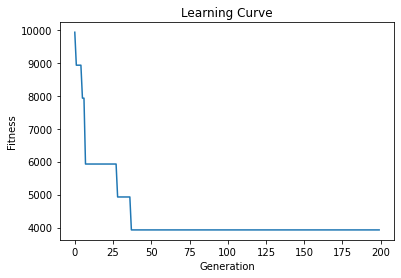

In [7]:
""" Input 1 """
# Load the input
requests, stock_length = input1, stock_length1

# Run the genetic algorithm
ga = GeneticAlgorithm(population_size=500, generation_num=200, mutation_rate=0.1, \
                      tournament_size=3, replacement_rate=0.2, elitism_rate=0.1)
ga.evolve()
best_solution = ga.population.get_fittest()

# Print the solutions
print("─" * 37 + f"\n\033[1m{'Wastage Amount:':<21}{-best_solution.fitness}" +
      f"\n\033[1m{'Stock Amount Needed:':<21}{best_solution.stock_needed()}\n" + \
            "─" * 37)

# print(f"\033[0mThe order in which the requests should be processed to obtain" +
#       f" the converged solution:\n{best_solution.genes}")

# Plot the learning curve
plotData(ga.learning_curve)

Observing the results for input 1, we can see that algorithm does a great job of converging to an optimal solution.

Fittest Chromosome in Generation 0:
Wastage:             74440
Stock needed:        86
Fittest Chromosome in Generation 10:
Wastage:             63240
Stock needed:        84
Fittest Chromosome in Generation 20:
Wastage:             57640
Stock needed:        83
Fittest Chromosome in Generation 30:
Wastage:             57640
Stock needed:        83
Fittest Chromosome in Generation 40:
Wastage:             52040
Stock needed:        82
Fittest Chromosome in Generation 50:
Wastage:             52040
Stock needed:        82
Fittest Chromosome in Generation 60:
Wastage:             52040
Stock needed:        82
Fittest Chromosome in Generation 70:
Wastage:             46440
Stock needed:        81
Fittest Chromosome in Generation 80:
Wastage:             46440
Stock needed:        81
Fittest Chromosome in Generation 90:
Wastage:             46440
Stock needed:        81
Fittest Chromosome in Generation 100:
Wastage:             40840
Stock needed:        80
Fittest Chromosome in Generation

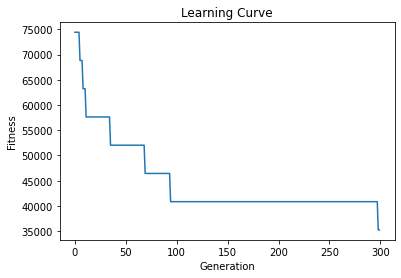

In [8]:
""" Input 2 """
# Load the input
requests, stock_length = input2, stock_length2

# Run the genetic algorithm
ga = GeneticAlgorithm(population_size=150, generation_num=300, mutation_rate=0.1, \
                      tournament_size=2, replacement_rate=0.2, elitism_rate=0.1)
ga.evolve()
best_solution = ga.population.get_fittest()

# Print the solutions
print("─" * 37 + f"\n\033[1m{'Wastage Amount:':<21}{-best_solution.fitness}" +
      f"\n\033[1m{'Stock Amount Needed:':<21}{best_solution.stock_needed()}\n" + \
            "─" * 37)

# print(f"\033[0mThe order in which the requests should be processed to obtain" +
#       f" the converged solution:\n{best_solution.genes}")

# Plot the learning curve
plotData(ga.learning_curve)

However, in the case of input 2, even though it achieves the asking stock (roll) number of less than 80, it could do better in terms of converging to a more optimal value.

Fittest Chromosome in Generation 0:
Wastage:             9690
Stock needed:        111
Fittest Chromosome in Generation 10:
Wastage:             7690
Stock needed:        107
Fittest Chromosome in Generation 20:
Wastage:             6690
Stock needed:        105
Fittest Chromosome in Generation 30:
Wastage:             6190
Stock needed:        104
Fittest Chromosome in Generation 40:
Wastage:             5690
Stock needed:        103
Fittest Chromosome in Generation 50:
Wastage:             5690
Stock needed:        103
Fittest Chromosome in Generation 60:
Wastage:             5190
Stock needed:        102
Fittest Chromosome in Generation 70:
Wastage:             4690
Stock needed:        101
Fittest Chromosome in Generation 80:
Wastage:             4690
Stock needed:        101
Fittest Chromosome in Generation 90:
Wastage:             4690
Stock needed:        101
Fittest Chromosome in Generation 100:
Wastage:             4690
Stock needed:        101
Fittest Chromosome in Generation

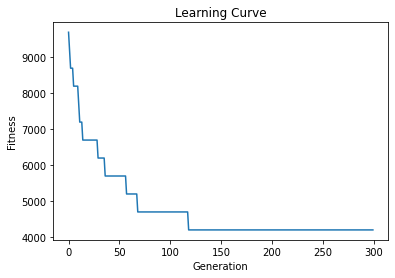

In [9]:
""" Input 3 """
# Load the input
requests, stock_length = input3, stock_length3

# Run the genetic algorithm
ga = GeneticAlgorithm(population_size=25, generation_num=300, mutation_rate=0.1, \
                      tournament_size=3, replacement_rate=0.4, elitism_rate=0.1)
ga.evolve()
best_solution = ga.population.get_fittest()

# Print the solutions
print("─" * 37 + f"\n\033[1m{'Wastage Amount:':<21}{-best_solution.fitness}" +
      f"\n\033[1m{'Stock Amount Needed:':<21}{best_solution.stock_needed()}\n" + \
            "─" * 37)

# print(f"\033[0mThe order in which the requests should be processed to obtain" +
#       f" the converged solution:\n{best_solution.genes}")

# Plot the learning curve
plotData(ga.learning_curve)

In the case of input 3, the algorithm converges slower due to the intput size. It does do a good job converging on an acceptable suboptimal value and it checks off the the $<115$ stock (roll) number requirement of the project.

Fittest Chromosome in Generation 0:
Wastage:             4005
Stock needed:        245
Fittest Chromosome in Generation 10:
Wastage:             3505
Stock needed:        240
Fittest Chromosome in Generation 20:
Wastage:             3205
Stock needed:        237
Fittest Chromosome in Generation 30:
Wastage:             3005
Stock needed:        235
Fittest Chromosome in Generation 40:
Wastage:             2905
Stock needed:        234
Fittest Chromosome in Generation 50:
Wastage:             2905
Stock needed:        234
Fittest Chromosome in Generation 60:
Wastage:             2805
Stock needed:        233
Fittest Chromosome in Generation 70:
Wastage:             2705
Stock needed:        234
Fittest Chromosome in Generation 80:
Wastage:             2605
Stock needed:        231
Fittest Chromosome in Generation 90:
Wastage:             2605
Stock needed:        231
Fittest Chromosome in Generation 100:
Wastage:             2505
Stock needed:        230
Fittest Chromosome in Generation

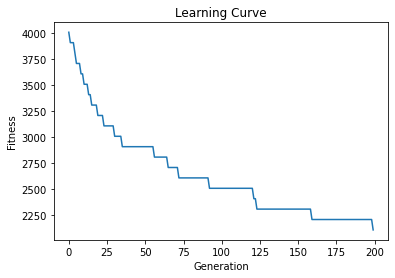

In [10]:
""" Input 4 """
# Load the input
requests, stock_length = input4, stock_length4

# Run the genetic algorithm
ga = GeneticAlgorithm(population_size=50, generation_num=200, mutation_rate=0.1, \
                      tournament_size=3, replacement_rate=0.2, elitism_rate=0.1)
ga.evolve()
best_solution = ga.population.get_fittest()

# Print the solutions
print("─" * 37 + f"\n\033[1m{'Wastage Amount:':<21}{-best_solution.fitness}" +
      f"\n\033[1m{'Stock Amount Needed:':<21}{best_solution.stock_needed()}\n" + \
            "─" * 37)

# print(f"\033[0mThe order in which the requests should be processed to obtain" +
#       f" the converged solution:\n{best_solution.genes}")

# Plot the learning curve
plotData(ga.learning_curve)

Similar to input 3, algorithm converges slower and it achieves acceptable suboptimal value that is $<235$ just as the project description is asks for.

<a id="three"></a>
## II. <span style="color:RGB(30, 190, 250)">Simulated Annealing

Simulated Annealing implemented here for the CSP has the following component and properties:

1. Solution Representation: Permutation, similar to the genetic algorithm chromosome
2. Cost: Stock wastage
3. Temperature: Initially at 1, decreasing exponentially decreased via some cooling rate and has a minimum
4. Solution Initilization: Done randomly
5. Neighbour selection: Random swap of two elements in solution permutaion
6. Acceptance Probabaility (P):
$$P(\Delta E, T) = \begin{cases} 
1 & \text{if } \Delta E < 0 \\
e^{\frac{-\Delta E}{T}} & \text{if } \Delta E \geq 0 
\end{cases}
$$ 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;where $\Delta E = E_{\text{new}} - E_{\text{old}}$ is the energy (cost) difference, $T$ is the current temperature.


Here is the SA code, it is consisted of two class.

First class, is the `Solution` class representing solutions.

In [11]:
class Solution:
    def __init__(self, permutation):
        self.permutation = permutation
        self.cost = self.calculate_cost()

    def calculate_cost(self):
        stock_wastage = 0
        stock_num = 0
        rem = 0
        for j in self.permutation:
            # See if there is a need for a new stock.
            if requests[j] <= rem:
                rem -= requests[j]
            else:
                stock_wastage += rem
                rem = stock_length - requests[j]
                stock_num += 1
        stock_wastage += rem
        
        return stock_wastage
    
    def stock_needed(self):
        stock_num = 0
        rem = 0
        for j in self.permutation:
            # See if there is a need for a new stock.
            if requests[j] <= rem:
                rem -= requests[j]
            else:
                rem = stock_length - requests[j]
                stock_num += 1
        
        return stock_num

Next, we have the `SimulatedAnnealing` class implementing the algorithm following the components and properties mentinoed before.

In [23]:
class SimulatedAnnealing:
    def __init__(self, cooling_rate=0.99995, min_temp=0.01):
        self.current_solution = self.initialize_solution()
        self.cooling_rate = cooling_rate
        self.min_temp = min_temp
        # To plot the learning curve later
        self.learning_curve = []
    

    def initialize_solution(self):
        # Randomly initialize the initial solution
        return Solution(random.sample(range(len(requests)), len(requests)))

    def anneal(self):
        current_temp = 1.0
        next_print = 0.95

        while current_temp > self.min_temp:
            neighbor = self.generate_neighbor(self.current_solution)

            # Check if the move to neighbor is premitted or not
            if self.acceptance_probability(self.current_solution.cost, neighbor.cost, current_temp) > random.random():
                self.current_solution = neighbor

            # Decrease temperature
            current_temp *= self.cooling_rate
            self.learning_curve.append(self.current_solution.cost)
            if current_temp < next_print:  
                print(f"\033[1;96mSolution in Temperature {current_temp}:\033[0m\n" + 
                    f"\033[0;30m{'Wastage:':<20} {self.current_solution.cost}\033[0m\n" +
                    f"\033[0;30m{'Stock needed:':<20} {self.current_solution.stock_needed()}\033[0m") 
                
                next_print -= 0.05

        return self.current_solution

    def generate_neighbor(self, solution):
        # Generate neigbor by swapping random elements
        new_perm = solution.permutation[:]
        i, j = sorted(random.sample(range(len(new_perm)), 2))
        new_perm[i], new_perm[j] = new_perm[j], new_perm[i]
        
        return Solution(new_perm)

    def acceptance_probability(self, old_cost, new_cost, temperature):
        if new_cost < old_cost:
            return 1.0
        return math.exp((old_cost - new_cost) / temperature)

Now, lets test on our inputs. First with input 1.

Solution in Temperature 0.9499924112828733:
Wastage:             4928
Stock needed:        53
Solution in Temperature 0.8999620933113102:
Wastage:             4928
Stock needed:        53
Solution in Temperature 0.849970136295103:
Wastage:             4928
Stock needed:        53
Solution in Temperature 0.7999903779604773:
Wastage:             4928
Stock needed:        53
Solution in Temperature 0.7499811600206698:
Wastage:             4928
Stock needed:        53
Solution in Temperature 0.6999762187030283:
Wastage:             4928
Stock needed:        53
Solution in Temperature 0.6499818949789145:
Wastage:             3928
Stock needed:        52
Solution in Temperature 0.5999777116681725:
Wastage:             3928
Stock needed:        52
Solution in Temperature 0.5499846299188639:
Wastage:             3928
Stock needed:        52
Solution in Temperature 0.4999899257176738:
Wastage:             3928
Stock needed:        52
Solution in Temperature 0.4499944799074408:
Wastage:         

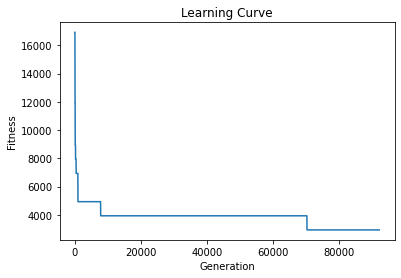

In [24]:
""" Input 1 """
# Load the input
requests, stock_length = input1, stock_length1

sa = SimulatedAnnealing()
best_solution = sa.anneal()

print(best_solution.calculate_cost())
print(best_solution.permutation)

# Print the solutions
print("─" * 37 + f"\n\033[1m{'Wastage Amount:':<21}{best_solution.calculate_cost()}" +
      f"\n\033[1m{'Stock Amount Needed:':<21}{best_solution.stock_needed()}\n" + \
            "─" * 37)

# print(f"\033[0mThe order in which the requests should be processed to obtain" +
#       f" the converged solution:\n{best_solution.permutation}")


# Plot the learning curve
plotData(sa.learning_curve)

Solution in Temperature 0.9499924112828733:
Wastage:             57640
Stock needed:        83
Solution in Temperature 0.8999620933113102:
Wastage:             52040
Stock needed:        82
Solution in Temperature 0.849970136295103:
Wastage:             46440
Stock needed:        81
Solution in Temperature 0.7999903779604773:
Wastage:             46440
Stock needed:        81
Solution in Temperature 0.7499811600206698:
Wastage:             46440
Stock needed:        81
Solution in Temperature 0.6999762187030283:
Wastage:             40840
Stock needed:        80
Solution in Temperature 0.6499818949789145:
Wastage:             40840
Stock needed:        80
Solution in Temperature 0.5999777116681725:
Wastage:             40840
Stock needed:        80
Solution in Temperature 0.5499846299188639:
Wastage:             40840
Stock needed:        80
Solution in Temperature 0.4999899257176738:
Wastage:             40840
Stock needed:        80
Solution in Temperature 0.4499944799074408:
Wastage

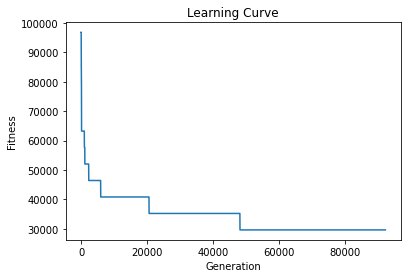

In [26]:
""" Input 2 """
# Load the input
requests, stock_length = input2, stock_length2

sa = SimulatedAnnealing(cooling_rate=0.99995)
best_solution = sa.anneal()

print(best_solution.calculate_cost())
print(best_solution.permutation)

# Print the solutions
print("─" * 37 + f"\n\033[1m{'Wastage Amount:':<21}{best_solution.calculate_cost()}" +
      f"\n\033[1m{'Stock Amount Needed:':<21}{best_solution.stock_needed()}\n" + \
            "─" * 37)

# print(f"\033[0mThe order in which the requests should be processed to obtain" +
#       f" the converged solution:\n{best_solution.permutation}")


# Plot the learning curve
plotData(sa.learning_curve)

Solution in Temperature 0.9499924112828733:
Wastage:             6690
Stock needed:        105
Solution in Temperature 0.8999620933113102:
Wastage:             5190
Stock needed:        102
Solution in Temperature 0.849970136295103:
Wastage:             4690
Stock needed:        101
Solution in Temperature 0.7999903779604773:
Wastage:             4190
Stock needed:        100
Solution in Temperature 0.7499811600206698:
Wastage:             4190
Stock needed:        100
Solution in Temperature 0.6999762187030283:
Wastage:             3690
Stock needed:        99
Solution in Temperature 0.6499818949789145:
Wastage:             3190
Stock needed:        98
Solution in Temperature 0.5999777116681725:
Wastage:             3190
Stock needed:        98
Solution in Temperature 0.5499846299188639:
Wastage:             3190
Stock needed:        98
Solution in Temperature 0.4999899257176738:
Wastage:             3190
Stock needed:        98
Solution in Temperature 0.4499944799074408:
Wastage:    

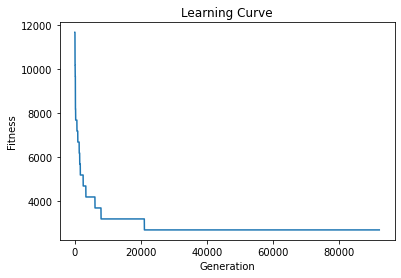

In [27]:
""" Input 3 """
# Load the input
requests, stock_length = input3, stock_length3

sa = SimulatedAnnealing()
best_solution = sa.anneal()

print(best_solution.calculate_cost())
print(best_solution.permutation)

# Print the solutions
print("─" * 37 + f"\n\033[1m{'Wastage Amount:':<21}{best_solution.calculate_cost()}" +
      f"\n\033[1m{'Stock Amount Needed:':<21}{best_solution.stock_needed()}\n" + \
            "─" * 37)

# print(f"\033[0mThe order in which the requests should be processed to obtain" +
#       f" the converged solution:\n{best_solution.permutation}")


# Plot the learning curve
plotData(sa.learning_curve)

Solution in Temperature 0.9499924112828733:
Wastage:             2505
Stock needed:        230
Solution in Temperature 0.8999620933113102:
Wastage:             1905
Stock needed:        224
Solution in Temperature 0.849970136295103:
Wastage:             1705
Stock needed:        222
Solution in Temperature 0.7999903779604773:
Wastage:             1705
Stock needed:        222
Solution in Temperature 0.7499811600206698:
Wastage:             1705
Stock needed:        222
Solution in Temperature 0.6999762187030283:
Wastage:             1605
Stock needed:        221
Solution in Temperature 0.6499818949789145:
Wastage:             1505
Stock needed:        220
Solution in Temperature 0.5999777116681725:
Wastage:             1505
Stock needed:        220
Solution in Temperature 0.5499846299188639:
Wastage:             1505
Stock needed:        220
Solution in Temperature 0.4999899257176738:
Wastage:             1505
Stock needed:        220
Solution in Temperature 0.4499944799074408:
Wastage

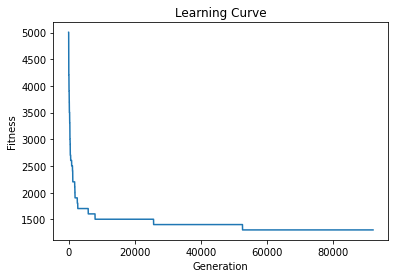

In [28]:
""" Input 4 """
# Load the input
requests, stock_length = input4, stock_length4

sa = SimulatedAnnealing()
best_solution = sa.anneal()

print(best_solution.calculate_cost())
print(best_solution.permutation)

# Print the solutions
print("─" * 37 + f"\n\033[1m{'Wastage Amount:':<21}{best_solution.calculate_cost()}" +
      f"\n\033[1m{'Stock Amount Needed:':<21}{best_solution.stock_needed()}\n" + \
            "─" * 37)

# print(f"\033[0mThe order in which the requests should be processed to obtain" +
#       f" the converged solution:\n{best_solution.permutation}")

# Plot the learning curve
plotData(sa.learning_curve)

Observing the results, in inputs 1 and 2, genetic algorithm and simulated annealing perfom about the same in terms of their convergence accuracy. However in inputs 3 and 4 there is a visible improvement in the convergence value. It should also be said that in many cases SA is faster than GA.

<a id="four"></a>
## III. <span style="color:RGB(30, 190, 250)">Hill Climbing

Due to the ambiguity of what is a neighbor and what is not, the implemented Hill Climbing algorithm here is a simple hill climb that generates neighbors for the current solution and checks to see if it is potentially a better solution that the current one. If so, the neighbor is set to be the current solution. The algorithm has a limit on the number times it generates neighbors with failure of being a better solution. If this limit is exceeded then the algorithm yield the current solution as the final solution.

Here is the implementation.

**NOTE** that the code in this section makes use of `Solution` class seen in the simulated annealing implementation, representing solutions as permutations for the order in which request to process.

In addition to the `Solution` class, there is a `HillClimbing` class implementing the hill climbing algorithm described above.

In [17]:
class HillClimbing:
    def __init__(self, neighbor_limit=500000):
        self.current_solution = self._initialize_solution()
        self.neighbor_limit = neighbor_limit
        # To plot the learning curve later
        self.learning_curve = []

    def _initialize_solution(self):
        # Randomly initialize the initial solution
        return Solution(random.sample(range(len(requests)), len(requests)))

    def descend(self):
        i = 1
        while True:
            improved = False
            for _ in range(self.neighbor_limit):
                neighbor = self._generate_neighbor(self.current_solution)

                # Move to neighbor if it's better
                if neighbor.cost < self.current_solution.cost:
                    self.current_solution = neighbor
                    self.learning_curve.append(self.current_solution.cost)
                    if i % 4 == 0
                    print(f"\033[1;96mSolution in Iteration {i}:\033[0m\n" + 
                        f"\033[0;30m{'Wastage:':<20} {self.current_solution.cost}\033[0m\n" +
                        f"\033[0;30m{'Stock needed:':<20} {self.current_solution.stock_needed()}\033[0m") 
                    improved = True
                    break  # Break the inner loop if improvement is found

            if not improved:
                # Exit the loop if no better neighbor is found after trying neighbor_limit times
                break
            
            i += 1

        return self.current_solution

    def _generate_neighbor(self, solution):
        new_perm = solution.permutation[:]
        neighborhood_type = random.choice(['single_swap', 'multi_swap', 
                                           'section_reverse', 'section_shuffle'])

        if neighborhood_type == 'single_swap':
            i, j = sorted(random.sample(range(len(new_perm)), 2))
            new_perm[i], new_perm[j] = new_perm[j], new_perm[i]

        if neighborhood_type == 'multi_swap':
            for _ in range(random.randint(2, 5)):
                i, j = sorted(random.sample(range(len(new_perm)), 2))
                new_perm[i], new_perm[j] = new_perm[j], new_perm[i]

        elif neighborhood_type == 'section_reverse':
            start, end = sorted(random.sample(range(len(new_perm)), 2))
            new_perm[start:end] = reversed(new_perm[start:end])

        else: 
            start, end = sorted(random.sample(range(len(new_perm)), 2))
            sub_list = new_perm[start:end+1]  
            random.shuffle(sub_list)  
            new_perm[start:end+1] = sub_list


        return Solution(new_perm)

Same as before, we will test this algorithm using inputs 1-4. Starting with input 1.

Solution in Iteration 1:
Wastage:             14928
Stock needed:        63
Solution in Iteration 2:
Wastage:             13928
Stock needed:        62
Solution in Iteration 3:
Wastage:             12928
Stock needed:        61
Solution in Iteration 4:
Wastage:             11928
Stock needed:        60
Solution in Iteration 5:
Wastage:             10928
Stock needed:        59
Solution in Iteration 6:
Wastage:             9928
Stock needed:        58
Solution in Iteration 7:
Wastage:             8928
Stock needed:        57
Solution in Iteration 8:
Wastage:             7928
Stock needed:        56
Solution in Iteration 9:
Wastage:             6928
Stock needed:        55


Solution in Iteration 10:
Wastage:             5928
Stock needed:        54
Solution in Iteration 11:
Wastage:             4928
Stock needed:        53
Solution in Iteration 12:
Wastage:             3928
Stock needed:        52
─────────────────────────────────────
Wastage Amount:      3928
Stock Amount Needed: 52
─────────────────────────────────────


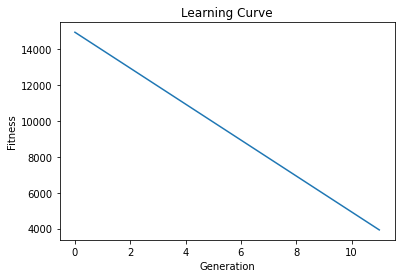

In [18]:
""" Input 1 """
# Load the input
requests, stock_length = input1, stock_length1

hc = HillClimbing()
best_solution = hc.descend()

# Print the solutions
print("─" * 37 + f"\n\033[1m{'Wastage Amount:':<21}{best_solution.calculate_cost()}" +
      f"\n\033[1m{'Stock Amount Needed:':<21}{best_solution.stock_needed()}\n" + \
            "─" * 37)

# print(f"\033[0mThe order in which the requests should be processed to obtain" +
#       f" the converged solution:\n{best_solution.permutation}")


# Plot the learning curve
plotData(hc.learning_curve)

Solution in Iteration 1:
Wastage:             80040
Stock needed:        87
Solution in Iteration 2:
Wastage:             74440
Stock needed:        86
Solution in Iteration 3:
Wastage:             68840
Stock needed:        85
Solution in Iteration 4:
Wastage:             63240
Stock needed:        84
Solution in Iteration 5:
Wastage:             57640
Stock needed:        83
Solution in Iteration 6:
Wastage:             52040
Stock needed:        82
Solution in Iteration 7:
Wastage:             46440
Stock needed:        81
Solution in Iteration 8:
Wastage:             40840
Stock needed:        80
─────────────────────────────────────
Wastage Amount:      40840
Stock Amount Needed: 80
─────────────────────────────────────


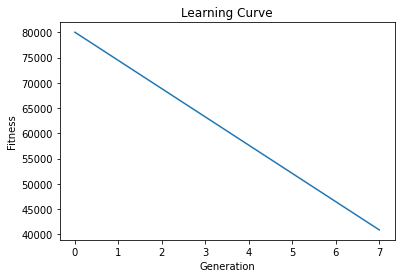

In [19]:
""" Input 2 """
# Load the input
requests, stock_length = input2, stock_length2

hc = HillClimbing(500000)
best_solution = hc.descend()

# Print the solutions
print("─" * 37 + f"\n\033[1m{'Wastage Amount:':<21}{best_solution.calculate_cost()}" +
      f"\n\033[1m{'Stock Amount Needed:':<21}{best_solution.stock_needed()}\n" + \
            "─" * 37)

# print(f"\033[0mThe order in which the requests should be processed to obtain" +
#       f" the converged solution:\n{best_solution.permutation}")


# Plot the learning curve
plotData(hc.learning_curve)

Solution in Iteration 1:
Wastage:             10690
Stock needed:        113
Solution in Iteration 2:
Wastage:             10190
Stock needed:        112
Solution in Iteration 3:
Wastage:             9690
Stock needed:        111
Solution in Iteration 4:
Wastage:             9190
Stock needed:        110
Solution in Iteration 5:
Wastage:             8690
Stock needed:        109
Solution in Iteration 6:
Wastage:             8190
Stock needed:        108
Solution in Iteration 7:
Wastage:             7690
Stock needed:        107
Solution in Iteration 8:
Wastage:             7190
Stock needed:        106
Solution in Iteration 9:
Wastage:             6690
Stock needed:        105
Solution in Iteration 10:
Wastage:             6190
Stock needed:        104
Solution in Iteration 11:
Wastage:             5690
Stock needed:        103
Solution in Iteration 12:
Wastage:             5190
Stock needed:        102
Solution in Iteration 13:
Wastage:             4690
Stock needed:        101
──────

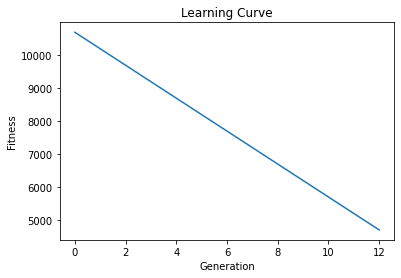

In [20]:
""" Input 3 """
# Load the input
requests, stock_length = input3, stock_length3

hc = HillClimbing(neighbor_limit=100000)
best_solution = hc.descend()

# Print the solutions
print("─" * 37 + f"\n\033[1m{'Wastage Amount:':<21}{best_solution.calculate_cost()}" +
      f"\n\033[1m{'Stock Amount Needed:':<21}{best_solution.stock_needed()}\n" + \
            "─" * 37)

# print(f"\033[0mThe order in which the requests should be processed to obtain" +
#       f" the converged solution:\n{best_solution.permutation}")


# Plot the learning curve
plotData(hc.learning_curve)

Solution in Iteration 1:
Wastage:             4605
Stock needed:        251
Solution in Iteration 2:
Wastage:             4505
Stock needed:        250
Solution in Iteration 3:
Wastage:             4405
Stock needed:        249
Solution in Iteration 4:
Wastage:             4305
Stock needed:        248
Solution in Iteration 5:
Wastage:             4205
Stock needed:        247
Solution in Iteration 6:
Wastage:             4005
Stock needed:        245
Solution in Iteration 7:
Wastage:             3905
Stock needed:        244
Solution in Iteration 8:
Wastage:             3805
Stock needed:        243
Solution in Iteration 9:
Wastage:             3705
Stock needed:        242
Solution in Iteration 10:
Wastage:             3605
Stock needed:        241
Solution in Iteration 11:
Wastage:             3505
Stock needed:        240
Solution in Iteration 12:
Wastage:             3405
Stock needed:        239
Solution in Iteration 13:
Wastage:             3305
Stock needed:        238
Solution

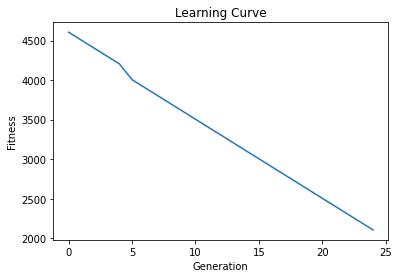

In [21]:
""" Input 4 """
# Load the input
requests, stock_length = input4, stock_length4

hc = HillClimbing(neighbor_limit=100000)
best_solution = hc.descend()

# Print the solutions
print("─" * 37 + f"\n\033[1m{'Wastage Amount:':<21}{best_solution.calculate_cost()}" +
      f"\n\033[1m{'Stock Amount Needed:':<21}{best_solution.stock_needed()}\n" + \
            "─" * 37)

# print(f"\033[0mThe order in which the requests should be processed to obtain" +
#       f" the converged solution:\n{best_solution.permutation}")


# Plot the learning curve
plotData(hc.learning_curve)

The algorithm performs well, achieving the performace asked for in inputs 1, 3, and 4 and getting really close in input 4.

Observing the outputs for these inputs, there appears to be a gap in performance between hill climbing and the other two algorithms. Hill climbing generally performs worse here compared to the other two more complex algorithms, genetic algorithm and simulated annealing. 

---

In conclusion, by observing the results from inputs 1-4, we can rank the algorithms implemented here, in terms of their general performance, in the following manner:
$$\text{Hill Climbing} < \text{Genetic} < \text{Simulated Annealing}$$ 